# Vehicle Detection and Tracking
In this project, our goal is to implement a pipeline to identify vehicles in a video from a front-facing camera on a car.

The pipeline is broken into 3 steps
* Build a classifier: to decide whether a square image is a car or not
* Sliding windows technique to search for vehicles in images
* Vehicle tracking: once we have a high confidence vehicle detection, we can eventually estimate where it will appear in each subsequent frame

We load some useful modules

In [1]:
import glob
import os
import time
import numpy as np
import pandas as pd
import cv2
import pickle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn import pipeline
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

## Build a car/noncar classifer
### Dataset
We have the following dataset

* Labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)
* Additional labeled data from [Udacity](https://github.com/udacity/self-driving-car/tree/master/annotations) which contains data from [CrowdAI](https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz) and from [Autti](https://s3.amazonaws.com/udacity-sdc/annotations/object-dataset.tar.gz)

In this project we start by using labeled data `vehicles.zip` and `non-vehicles.zip`. Let's do some data exploration

In [2]:
def list_imgs(imgdirs, ext = 'png'):
    imgfiles = []
    for imgdir in imgdirs:
        fns = glob.glob('{}/*.{}'.format(imgdir, ext))
        imgfiles += list(np.sort(fns))
    return imgfiles

dataset_csv = 'datas/dataset.csv'
if not os.path.isfile(dataset_csv):
    cars = list_imgs(['datas/vehicles/GTI_Left',
                      'datas/vehicles/GTI_Right'
                      'datas/vehicles/GTI_MiddleClose',
                      'datas/vehicles/GTI_Far',
                      'datas/vehicles/KITTI_extracted'])
    noncars = list_imgs(['datas/non-vehicles/GTI',
                         'datas/non-vehicles/Extras'])

    print('Number of car samples     {}'.format(len(cars)))
    print('Number of non-car samples {}'.format(len(noncars)))

    # create pd.DataFrame and save it to csv
    flags = [1]*len(cars) + [0]*len(noncars)
    dataset = pd.DataFrame({'file':cars+noncars, 'is_car':flags})
    dataset.to_csv(dataset_csv, index=False)
else:
    dataset = pd.read_csv(dataset_csv)
    cars = dataset['file'][np.where(dataset['is_car']==1)[0]].values
    noncars = dataset['file'][np.where(dataset['is_car']==0)[0]].values
    print('Number of car samples     {}'.format(len(cars)))
    print('Number of non-car samples {}'.format(len(noncars)))

Number of car samples     7709
Number of non-car samples 8968


Let check the shape of input images

In [3]:
a_car_sample = mpimg.imread(cars[0])
print('Shape of car sample    {} of type {}'.format(a_car_sample.shape, a_car_sample.dtype))
a_noncar_sample = mpimg.imread(noncars[0])
print('Shape of noncar sample {} of type {}'.format(a_noncar_sample.shape, a_noncar_sample.dtype))

print('\nInput max/min {:.3f}/{:.3f}'.format(np.max(a_car_sample), np.min(a_car_sample)))
print('Input dtype: {}'.format(a_car_sample.dtype))

Shape of car sample    (64, 64, 3) of type float32
Shape of noncar sample (64, 64, 3) of type float32

Input max/min 1.000/0.027
Input dtype: float32


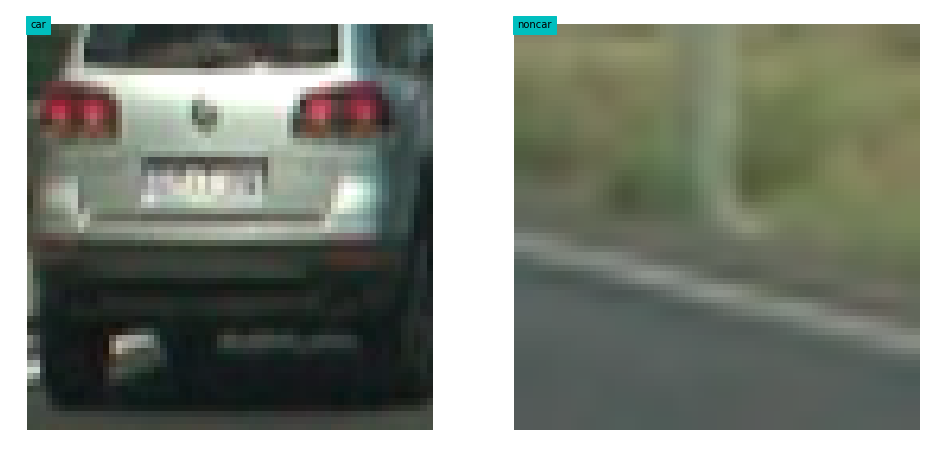

In [4]:
def show_img(img, label, ax = None, cmap=None):
    '''
    this function show image & label
    '''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    # draw image
    if label is not None:
        ax.text(0, 0, label, color='k',backgroundcolor='c', fontsize=10)
    
    ax.imshow(img, cmap=cmap)
    ax.axis('off')

def view_imgs(imgs, labels, figsize, multi_col = True, sharex = True, sharey = True):
    nrows = 1 if multi_col else len(labels)
    ncols = len(labels) if multi_col else 1
    fig, axes = plt.subplots(figsize= figsize, nrows=nrows, ncols=ncols, sharey=sharex, sharex=sharey)
    for i, ax in enumerate(axes.flatten()):
        show_img(imgs[i], labels[i], ax)

def grid_view(imgs, labels, figsize, nrows, ncols, sharex=True, sharey=True):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, sharey=sharex, sharex=sharey)
    for i, ax in enumerate(axes.flatten()):
        show_img(imgs[i], labels[i], ax)
        
view_imgs([a_car_sample, a_noncar_sample], ['car', 'noncar'], (16,8))        

So the input is of type `png` and when readed by `mpimg`, each sample is a `RGB` of shape `(64,64,3)` with each cell has value between [0.0, 1.0].

### Features
The next step in building our car/noncar classifier is to build a set of features to be used as `input` for our classifier. As suggested in the project page, one could combine color-based features and shape-based features:

* color-based features: histograms of color and spatial binning of color
* shape-based features: HOG features

These function is implemented in `lesson_utils.py`

In [5]:
from lesson_utils import get_bin_spatial, get_color_hist, get_hog

Let's visualize these features

#### Histogram of color
We visualize histogram of color of car v.s non-car sample

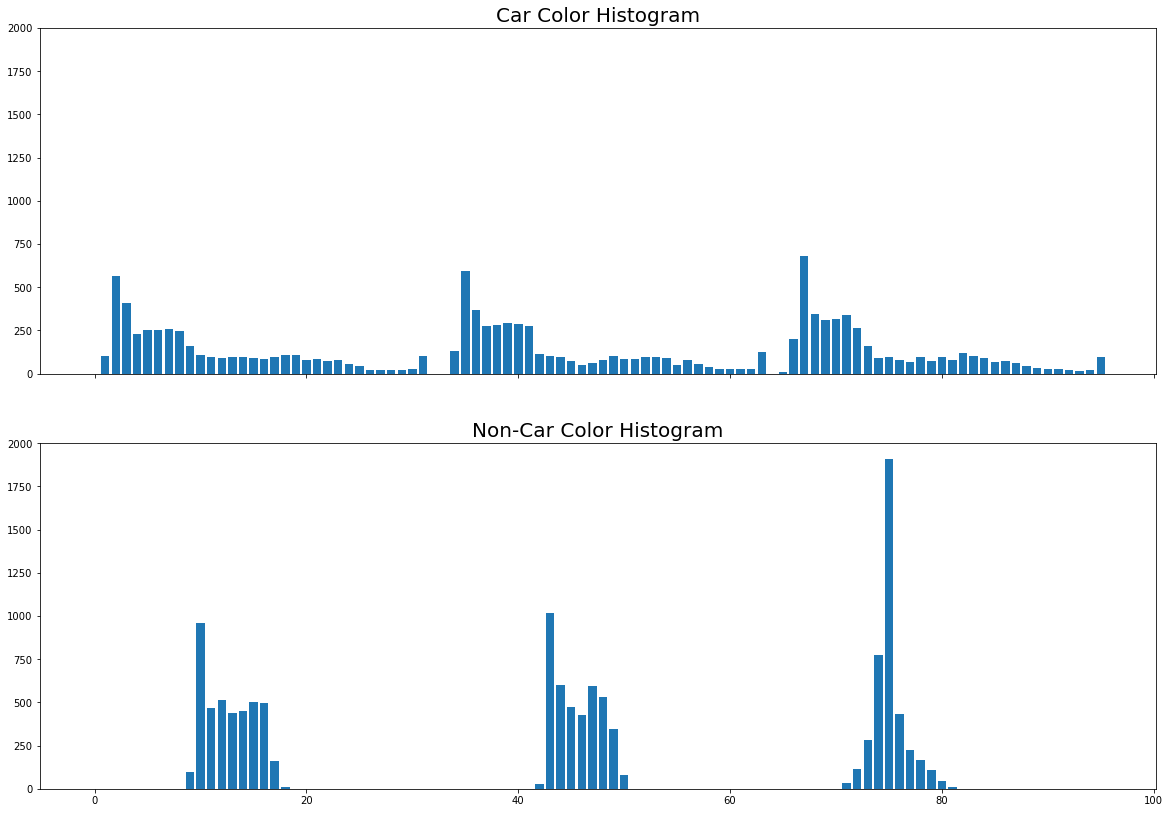

In [6]:
def visualize_hist(img_car, img_noncar, figsize):    
    hist_car = get_color_hist(img_car, bins_range=(0.0, 1.0))
    hist_noncar = get_color_hist(img_noncar, bins_range=(0.0, 1.0))
    x = np.arange(len(hist_car))
    
    fig, axes = plt.subplots(figsize= figsize, nrows=2, ncols=1, sharey=True, sharex=True)
    ax1, ax2 = axes.flatten()
    ax1.bar(x, hist_car)
    ax1.set_title('Car Color Histogram', fontsize=20)
    ax2.bar(x, hist_noncar)
    ax2.set_title('Non-Car Color Histogram', fontsize=20)

visualize_hist(a_car_sample, a_noncar_sample, (20,14))

For above example, histogram of car v.s non-car are quite different.

#### HOG feature
Let's view HOG of a car vs non-car

/home/minhvu/workplaces/infra/anaconda3/envs/tf_gpu_head/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


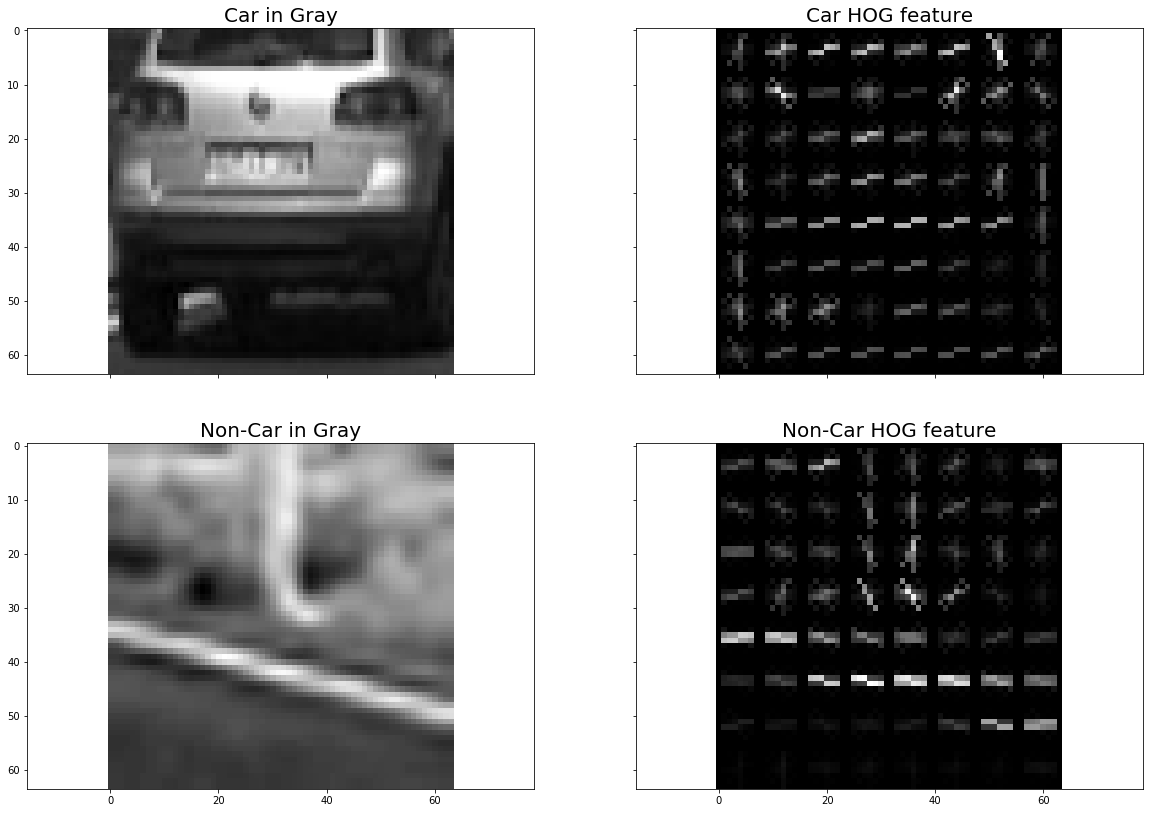

In [7]:
def visualize_hog(img_car, img_noncar, figsize):
    yuv_car = cv2.cvtColor(img_car, cv2.COLOR_RGB2YUV)
    yuv_noncar = cv2.cvtColor(img_noncar, cv2.COLOR_RGB2YUV)
    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    _, hog_car = get_hog(yuv_car, 
                         orient=orient, pix_per_cell=pix_per_cell, 
                         cell_per_block=cell_per_block, hog_channel=0,
                         feat_vec=False, vis=True)
    _, hog_noncar = get_hog(yuv_noncar, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, hog_channel=0,
                            feat_vec=False, vis=True)
    
    # draw image
    fig, axes = plt.subplots(figsize= figsize, nrows=2, ncols=2, sharey=True, sharex=True)
    ax1, ax2, ax3, ax4 = axes.flatten()
    ax1.imshow(yuv_car[:,:,0], cmap='gray')
    ax1.set_title('Car in Gray', fontsize=20)
    ax2.imshow(hog_car, cmap='gray')
    ax2.set_title('Car HOG feature', fontsize=20)
    ax3.imshow(yuv_noncar[:,:,0], cmap='gray')
    ax3.set_title('Non-Car in Gray', fontsize=20)
    ax4.imshow(hog_noncar, cmap='gray')
    ax4.set_title('Non-Car HOG feature', fontsize=20)
    
visualize_hog(a_car_sample, a_noncar_sample, (20,14))

The HOG feature will capture the shape of the object indepedent of the color so it might be more robust than color-based feature.

#### Spatial binning feature
The spatial binning feature is of high dimensional and it's not easy to visualize it. We skip it for now.

#### Combine features
Now let's combine the above features, this is implemented in `extract_features` in `lesson_utils.py`

In [8]:
from lesson_utils import extract_features
feats_setting = {'color_space'    : 'YCrCb',
                 'feats'          : ['bin_spatial', 'color_hist', 'hog'],
                 'spatial_size'   : (32, 32),
                 'hist_bins'      : 32,
                 'bins_range'     : (0.0, 1.0),
                 'orient'         : 9,
                 'pix_per_cell'   : 8,
                 'cell_per_block' : 2,
                 'hog_channel'    : 0}
X,y = extract_features(dataset['file'], dataset['is_car'], **feats_setting)

/home/minhvu/workplaces/infra/anaconda3/envs/tf_gpu_head/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


#### Normalize feature
As suggested in the project page, the feature from `feat_color_hist` might be not same range as feature from `feat_hog`, so we need to normalize our combined feature. This can be done via `StandardScaler` from `sklearn`, we will use it when training our classifier using `Pipeline`.

### Train our classifier
Let's train our classifier, we will use `Pipeline` from `sklearn`, we also split our training data into train/validation set using `train_test_split` from `sklearn`

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
print('Training input shape   {}'.format(X_train.shape))
print('Validation input shape {}'.format(X_test.shape))

ts = time.time()
clf = pipeline.Pipeline([('normalization', StandardScaler()),
                         ('classification', LinearSVC(loss='hinge', C=1))])
clf.fit(X_train, y_train)
print('Training time {:.2f} seconds'.format(time.time() - ts))
print('Training accuracy   {:.2f}%'.format(100*clf.score(X_train, y_train)))
print('Validation accuracy {:.2f}%'.format(100*clf.score(X_test, y_test)))

Training input shape   (26683, 4932)
Validation input shape (6671, 4932)
Training time 19.43 seconds
Training accuracy   100.00%
Validation accuracy 99.01%


Our classifier works well with validation accuracy `96.58%`, next we will try to tune our parameters and img-features to improve our classifier.

### Tuning our classifier
We have the following parameters
* `color_space`: the color space that we use to generate image features
* `spatial_size`: to build binning-spatial, the default value is (32,32)
* `hist_bin`: the number of bin for histogram-color features
* `orient, pix_per_cell, cell_per_block, hog_channel`: parameters for hog features

In [10]:
trained_clf = {k : feats_setting[k] for k in feats_setting}
trained_clf['clf'] = clf
with open('trained_clf.pkl', 'wb') as f:
    pickle.dump(trained_clf, f)

## Sliding window search
Now we have trained a classifier, the next task is to detect car(s) in our images. As suggested in the project page, we will use sliding-window-search technique i.e we step across an image in a gridpattern and run our classifier on
each window to detech if a window contain a car or not.

We use the function defined in the project pages

(720, 1280, 3)


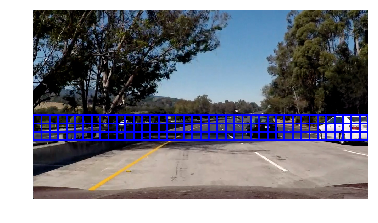

In [11]:
from lesson_utils import slide_window, draw_boxes
x_left_right = [None, None]
y_top_bottom = [400, 496]
xy_window    = (64,64)
xy_overlap   = (0.5, 0.5)
test_img = mpimg.imread('test_images/test5.jpg')
bboxes = slide_window(test_img.shape, 
                      x_start_stop=x_left_right, 
                      y_start_stop=y_top_bottom, 
                      xy_window=xy_window,
                      xy_overlap=xy_overlap)

test_img_bb = draw_boxes(test_img, bboxes)
show_img(test_img_bb, None)
print(test_img.shape)

### Multi-scale 
Since a car in our image can appear as small or big depending on its position, we should use multi-scale sliding window to detech vehicles in our image. Note that this will increase the number of searching windows, so we need to employ the following trick to reduce the number of searching windows
* restrict the search area (where vehicles might appear)
* vehicles that appear small will be near the horizon

Looking at the test images we decide to use the following scales and regions

In [12]:
def ms_slide_window(img_shape, 
                    scales = [64, 96, 128, 160, 160],
                    x_start_stops = [[None, None],  [None, None], [None, None], [0,    500],  [820, 1280]],
                    y_start_stops = [[400, 500]  , [400,  550],  [400,  600],  [400,  650],  [400,  650]],
                    xy_overlaps   = [0.75, 0.75, 0.75, 0.75, 0.75]):
    bboxes = []
    colors = []
    for i, scale in enumerate(scales):
        boxes = slide_window(img_shape, 
                             x_start_stop=x_start_stops[i],
                             y_start_stop=y_start_stops[i],
                             xy_window=(scale, scale),
                             xy_overlap=(xy_overlaps[i], xy_overlaps[i]))
        bboxes += boxes
        colors += [i]*len(boxes)
    return bboxes, colors

def visualize_ms(imgfiles, img_shape, figsize=(16, 25)):
    bboxes, _ = ms_slide_window(test_img.shape)
    imgs = []
    labels = []
    for img_fn in imgfiles:    
        img = mpimg.imread(img_fn)
        img_bb = draw_boxes(img, bboxes)
        imgs += [img, img_bb]
        labels += [img_fn, '{}_bb'.format(img_fn)]
    grid_view(imgs, labels, ncols=2, nrows=len(imgs)//2, figsize=figsize)

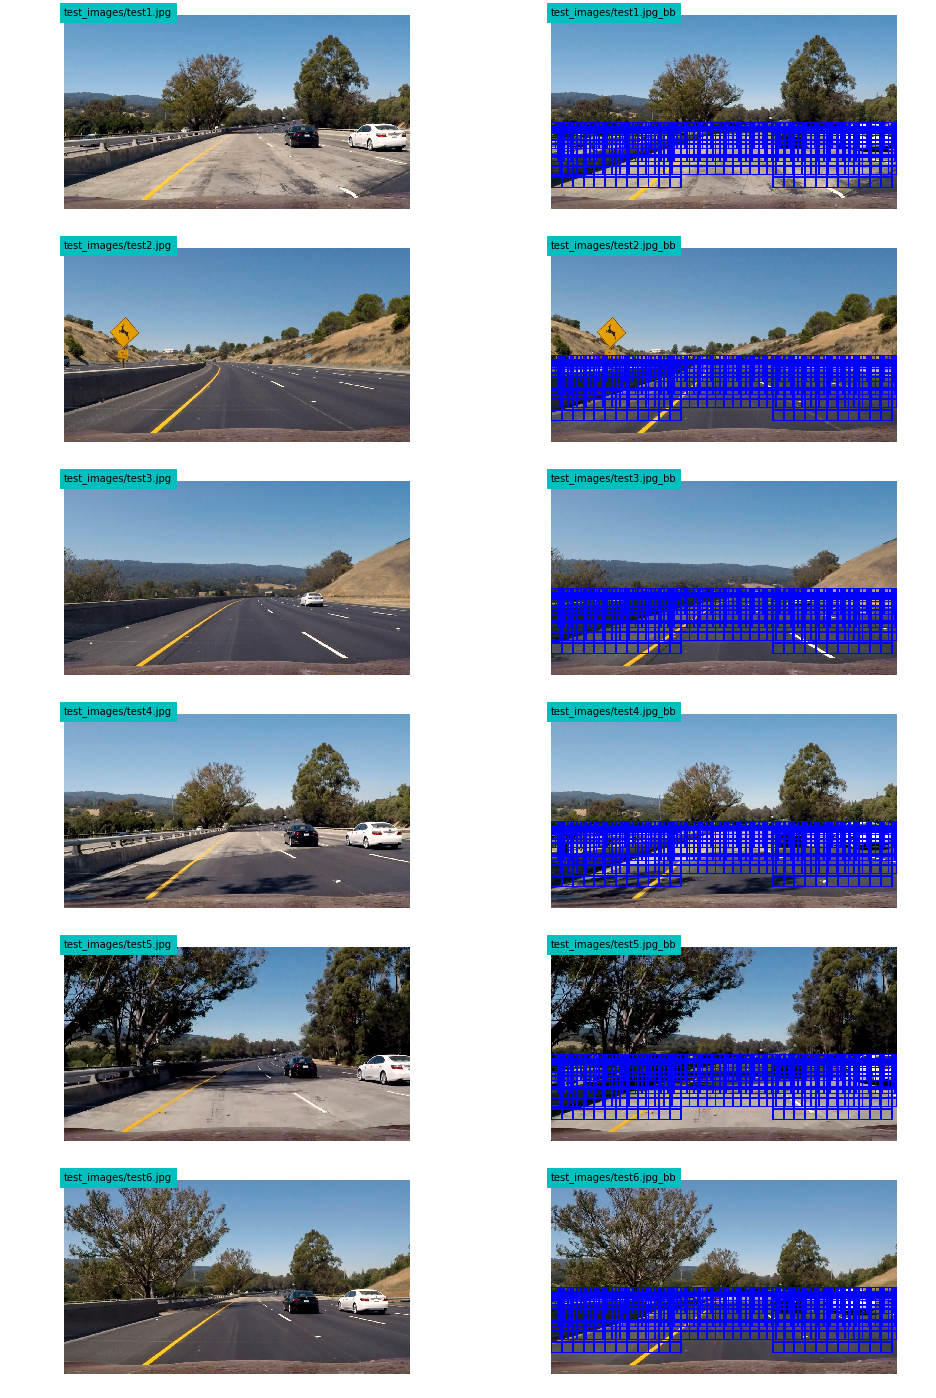

In [13]:
visualize_ms(list_imgs(['test_images'], 'jpg'), test_img.shape)

Now let apply our classifier with multi-scale search

Number of search windows 543


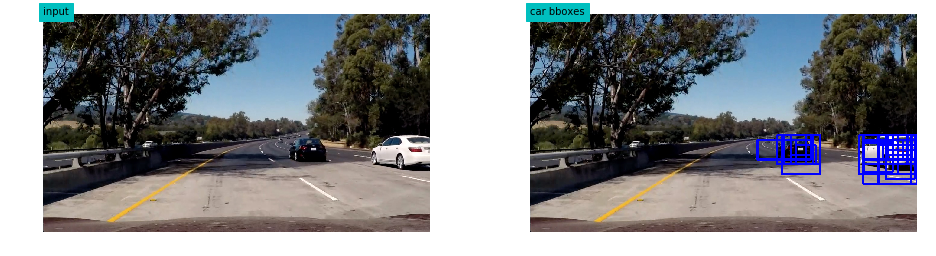

In [24]:
from lesson_utils import search_windows

bboxes, _ = ms_slide_window(test_img.shape)
print('Number of search windows {}'.format(len(bboxes)))
car_bboxes = search_windows(test_img, bboxes, clf, **feats_setting)
test_img_carbb = draw_boxes(test_img, car_bboxes)
view_imgs([test_img, test_img_carbb], ['input', 'car bboxes'], figsize=(16,4))

Using multi-scale sliding windows, we might encounter the following issue

* it might detect one car in multiple windows
* it might have false-positive

As suggested in the project page, we can use the heat-map to improve the stability

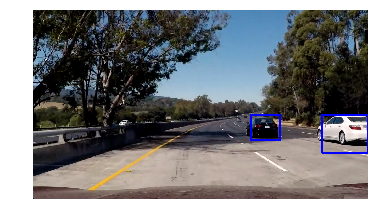

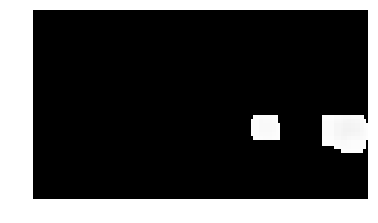

In [25]:
from lesson_utils import heat_map_bbox
hm_bboxes, hm = heat_map_bbox(test_img, car_bboxes, threshold=2, debug=True)
test_img_hmbb = draw_boxes(test_img, hm_bboxes)
show_img(test_img_hmbb, None)
show_img(hm, None, cmap='hot')

Now we put all above pipeline into a function so that we can apply to our video

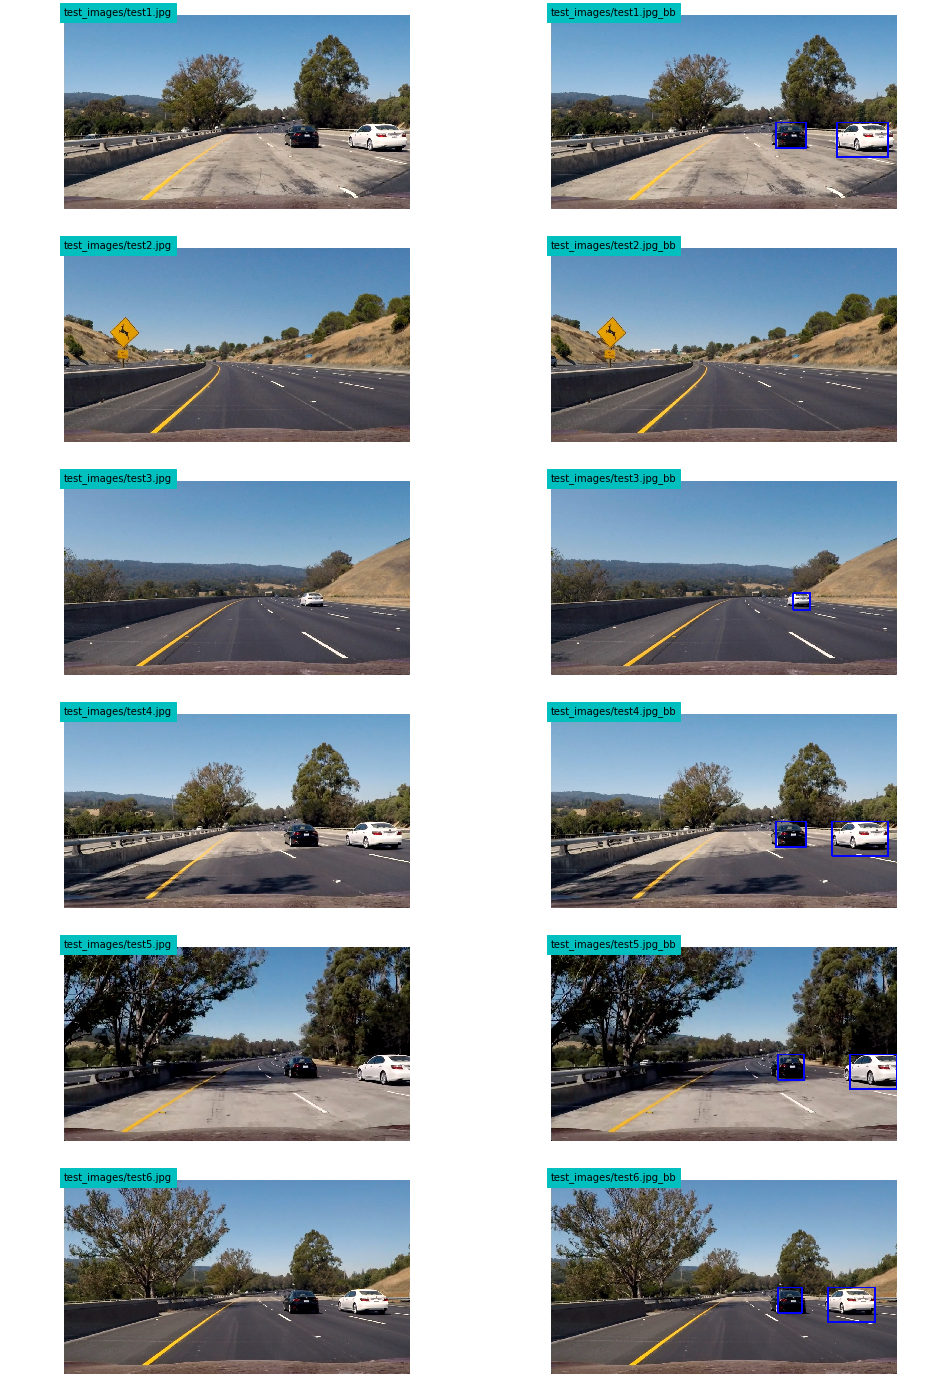

In [16]:
from pipeline import pipeline_single_img

def visualize_bboxes(imgfiles, windows, clf, figsize,**kwargs):
    imgs = []
    labels = []
    for img_fn in imgfiles:    
        img = mpimg.imread(img_fn)
        img_bb = pipeline_single_img(img, windows, clf, **kwargs)
        imgs += [img, img_bb]
        labels += [img_fn, '{}_bb'.format(img_fn)]
    
    grid_view(imgs, labels, ncols=2, nrows=len(imgs)//2, figsize=figsize)

windows, _  = ms_slide_window(test_img.shape)    
visualize_bboxes(list_imgs(['test_images'], 'jpg'), windows, clf, (16,25), **feats_setting)

To improve stability of vehicle tracking, we will integrate the heat-map over frames, this is done in class `BoundingBoxes` in `pipeline.py`

## Vehicle Detection on Video
Now we apply above pipeline to detect vehicles in `project_video.mp4`, first let's extract the video to 

In [29]:
from pipeline import pipeline_video_memory, BoundingBoxes

input_file  = 'project_video.mp4'
output_file = 'project_video_out.mp4'
bboxes_obj  = BoundingBoxes(test_img.shape, 
                            max_frames=3,
                            threshold=5) 
pipeline_video_memory(input_file, 
                      output_file, 
                      bboxes_obj, 
                      bboxes,
                      clf, 
                      **feats_setting)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [35:59<00:01,  1.66s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

File is saved to project_video_out.mp4


In [30]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

We notice some false-positive around second 7-9, we extract sub-clip to 

In [27]:
from pipeline import pipeline_single_img_memory
from moviepy.editor import VideoFileClip

bboxes_obj  = BoundingBoxes(test_img.shape, 
                            max_frames=3,
                            threshold=5) 

subclip = VideoFileClip(input_file).subclip(7, 9)
process_image = lambda raw_rgb: pipeline_single_img_memory(raw_rgb, bboxes_obj, bboxes, clf, **feats_setting)
clip_lane_line = subclip.fl_image(process_image)

out_file = 'subclip.mp4'
clip_lane_line.write_videofile(out_file, audio=False)

[MoviePy] >>>> Building video subclip.mp4
[MoviePy] Writing video subclip.mp4


 98%|█████████▊| 50/51 [01:26<00:01,  1.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: subclip.mp4 



In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_file))